In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd

In [4]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

# Set experiment(s) to analyze


In [5]:
exp_ids=['2018_03_12_14_18_25_Microwave freq scan']
assorted={}
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Coudn't find processed qdp. Loading and saving
qdp has been dumped to :Y:/Analysis/2018_03_12/2018_03_12_14_18_25_Microwave freq scan/qdp.txt


<IPython.core.display.Javascript object>


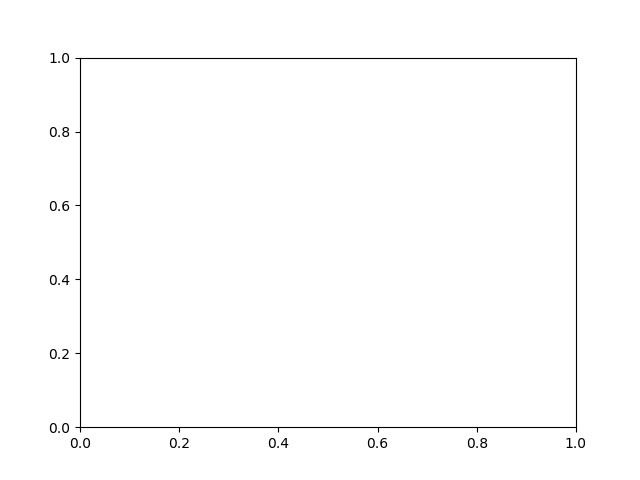

NameError: name 'retention' is not defined

In [9]:
fig, ax = plt.subplots()
fit_guesses=[0.8,0.013,0.005,0]
fitted_parameters=[]
for roi in [1,2]:
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o')
    fit = curve_fit(gaussian,data,reten,fit_guesses)
    print "ROI:{}, amplitude : {}, freq: {} , sigma:{}, offset:{}".format(roi,fit[0][0],fit[0][1],fit[0][2],fit[0][3])
    fitted_parameters.append(fit[0])
    #print fit[0]
    xarray=np.linspace(np.min(data),np.max(data),100)
    yfit=gaussian(xarray, np.float(fit[0][0]),np.float(fit[0][1]),np.float(fit[0][2]),np.float(fit[0][3]))
    plt.plot(xarray,yfit,label="ROI:{}".format(roi))

plt.show()
ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
ax.legend()

<IPython.core.display.Javascript object>


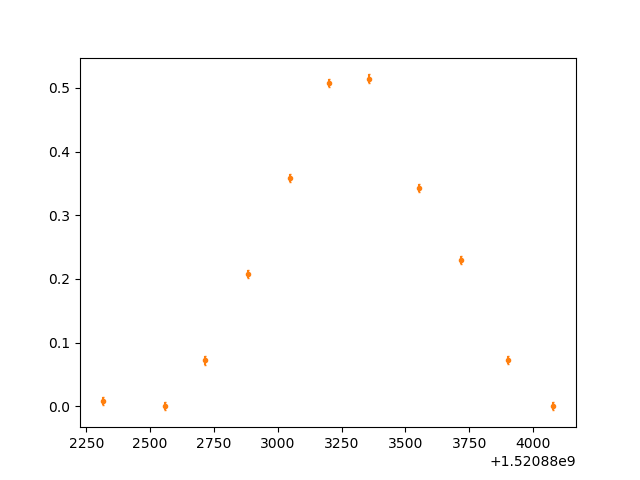

<Container object of 3 artists>

In [6]:
roi=1
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
xdata=flatten(assorted['timestamps'])
ydata=np.array(flatten(assorted['retentions'][roi]))
err=np.array(flatten(assorted['errors'][roi]))
fig, ax = plt.subplots()
#print xdata
ax.errorbar(xdata,ydata,yerr=err,label="ROI:{}".format(roi),fmt='o',markersize=3,color=colors[roi],capsize=1)
#xfmt=md.DateFormatter('%H:%M')

In [7]:
assorted={}
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_12/2018_03_12_14_18_25_Microwave freq scan/qdp.txt


In [8]:
savefig=False
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
fit_guesses=[30,0.4,2,0,0.5]
roi_dependency=[0,0,0,0,0]
fitted_parameters=[]
for roi in [1,2]:
    data = []
    timedata=[]
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(dates,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',markersize=3,color=colors[roi],capsize=1)
    ax.xaxis.set_major_formatter(xfmt)
    datemin = dt.datetime(2018, 3, 5,0,0,0)
    datemax = dt.datetime(2018, 3, 5,4,0,0)
    ax.set_xlim(datemin, datemax)

<IPython.core.display.Javascript object>

NameError: name 'retention' is not defined

# Analyzing experiments without atoms

In [3]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
 'timestamp_measurements',
 'timestamp_iteration']

exp_ids=['2018_03_11_21_22_49_Closed loop, no atom, AAS testing, N=200',
        '2018_03_12_01_34_24_Closed loop, no atom, AAS testing, N=200']

data={}
for j in range(0,len(exp_ids)):
    exp_id=exp_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)
    

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_11/2018_03_11_21_22_49_Closed loop, no atom, AAS testing, N=200/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_12/2018_03_12_01_34_24_Closed loop, no atom, AAS testing, N=200/qdp.txt


<IPython.core.display.Javascript object>


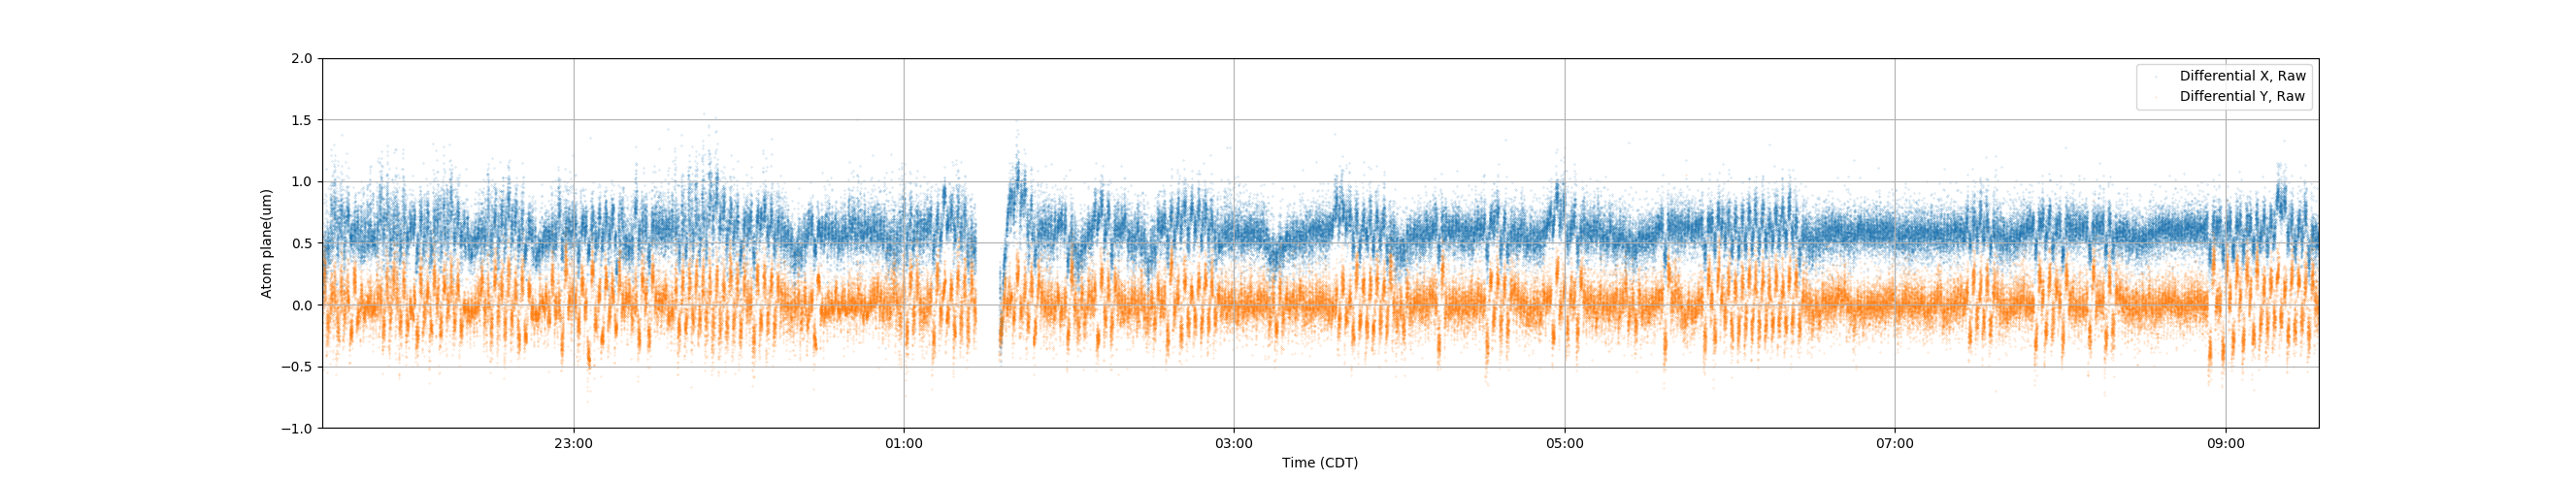

In [10]:
# Raw plotting
savefig=True
data_cutoff=900
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data[keylist[4]]))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=0.05,alpha=0.5,label='Differential X, Raw')
ax.set_xlim(dates[0],dates[-1])

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=0.05,alpha=0.5,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
ax.set_ylim(-1,2)
if savefig:
    plt.savefig('Alignment_overnight_Closedloop.png')

In [5]:
# Using Pandas
data_cutoff=900
flattendedtimestamps=np.array(flatten(data[keylist[4]]))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

samplerate='1S'
offsetX=(flatteneddata0-flatteneddata2)[0]
offsetY=(flatteneddata1-flatteneddata3)[0]
df=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY,
                 'Red X': flatteneddata0,
                 'Red Y': flatteneddata1,
                 'FORT X': flatteneddata2,
                 'FORT Y': flatteneddata3
                },index=dates)

<IPython.core.display.Javascript object>


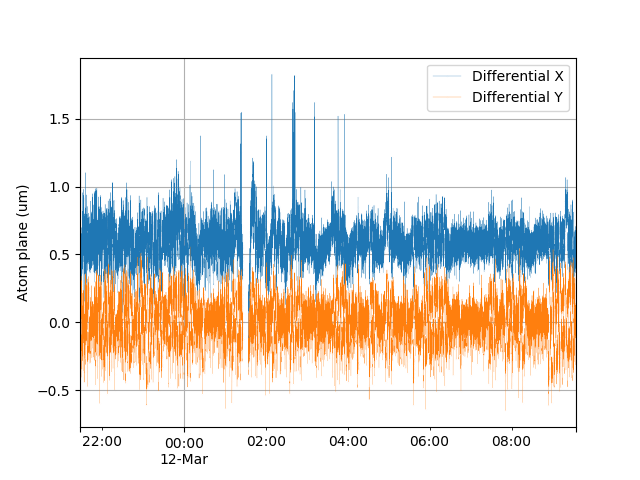

In [6]:
samplerate='1S'
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Differential X','Differential Y'],lw=0.2,marker='.',markersize=0.02)
#data_to_plot2.plot(y='Differential Y',lw=0.2)
#ax.set_xlabel('Atom plane (um)')
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()
#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-1.5, 1.5)

#ax=data_to_plot2.plot(x='Differential X', y='Differential Y',lw=0.2,marker='.',markersize=0.02, alpha=0.5)

In [14]:
# Trying to do a high pass filter.
samplerate='3S'
cutoffrate='1H'
original_resampled=df.resample(samplerate).mean()
downsampled=df.resample(cutoffrate).mean()
upsampled=downsampled.resample(samplerate).pad()
lowpassfiltered=upsampled

3S
Differential X    0.200682
Differential Y    0.158255
dtype: float64


<IPython.core.display.Javascript object>


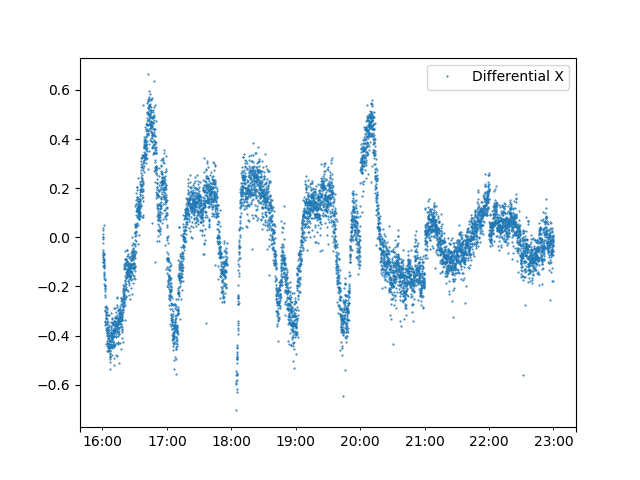

In [16]:
newdata=original_resampled-lowpassfiltered
print samplerate
print newdata.std()
#print newdata
#newdata = newdata[np.isfinite(newdata['Differential X'])]
#newdata.plot(y='Differential X',style='.',alpha=1, ms=1)
# newdata.plot(y='Differential X',lw=0.2)
#newdata.plot(y='Differential Y',style='.',alpha=1, ms=1)
# newdata.plot(y='Differential Y',lw=0.2)

# Allan deviation

In [7]:
# Allan 
tau_list=range(1,10000)
samplerates=[]
for i in tau_list:
    samplerates.append('{}S'.format(i))
        
samplerate='1S'

var_list={}

original_resampled=df.resample(samplerate).mean()

for i in range(0,len(tau_list)):
    avg_samplerate=samplerates[i]
    tau=tau_list[i]
    #print i
    try:
        downsampled=df.resample(avg_samplerate).mean() # Takes block-average for given time chuck size
        for key in downsampled:
            values=downsampled[key].values
            Xtau=values[1:]
            Xo=values[0:-1]
            var=np.nanmean(np.abs(Xtau-Xo))
            if i==0:
                var_list[key]=[]
            var_list[key].append(var)
    except:
        pass
    #Y=downsampled['Differential X'].values
    #Xstd.append(newdata['Differential X'].std())
    #Ystd.append(newdata['Differential Y'].std())

<IPython.core.display.Javascript object>


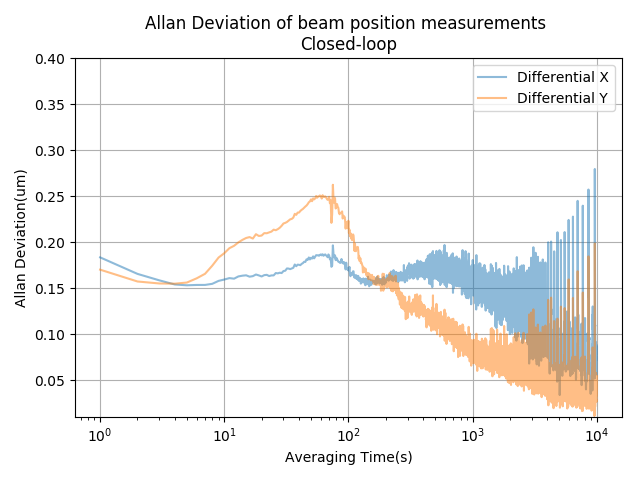

In [14]:
fig, ax = plt.subplots()
#xdata=tau_lists
#for key in var_list:
for key in ['Differential X','Differential Y']:
    ax.semilogx(tau_list, np.sqrt(0.5*np.array(var_list[key])),label=key,alpha=0.5)
#ax.semilogx(tau_list, np.sqrt(Yvar_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Xvariance_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Yvariance_list),label='Diff Y',alpha=0.5)
ax.legend()
#ax.set_xlim(1,)
ax.set_title('Allan Deviation of beam position measurements \nClosed-loop')
ax.set_xlabel('Averaging Time(s)')
ax.set_ylabel('Allan Deviation(um)')
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.01,0.4)
ax.grid()
plt.tight_layout()
if savefig:
    plt.savefig('AllanDeviation_Closedloop.png')
    plt.savefig('AllanDeviation_Closedloop.pdf')

<IPython.core.display.Javascript object>


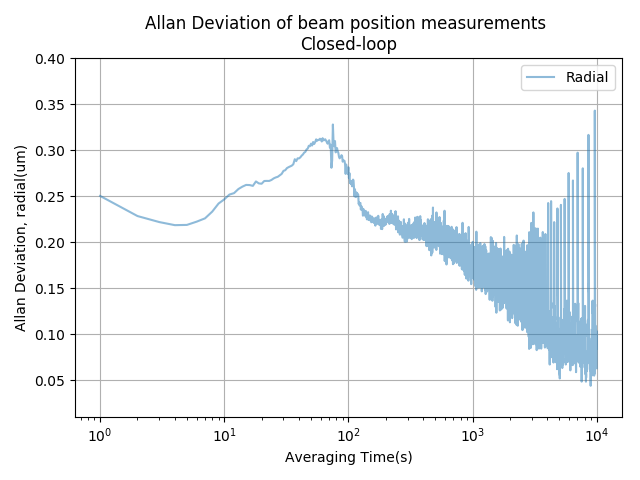

In [13]:
fig, ax = plt.subplots()
rms=np.sqrt(0.5*np.array(var_list['Differential X'])+0.5*np.array(var_list['Differential Y']))
ax.semilogx(tau_list, rms,label='Radial',alpha=0.5)
#ax.semilogx(tau_list, np.sqrt(Yvar_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Xvariance_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Yvariance_list),label='Diff Y',alpha=0.5)
ax.legend()
#ax.set_xlim(1,)
ax.set_title('Allan Deviation of beam position measurements \nClosed-loop')
ax.set_xlabel('Averaging Time(s)')
ax.set_ylabel('Allan Deviation, radial(um)')
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.01,0.4)
ax.grid()
plt.tight_layout()